In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

In [10]:
ts_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

In [11]:
ts_df.head()

,host_id,host_is_superhost,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,...,neighborhood_Madison,neighborhood_Midtown,neighborhood_North_Nashville,neighborhood_Parkwood,neighborhood_South_Nashville,neighborhood_Southeast_Nashville,neighborhood_West_Nashville,neighborhood_Whites_Creek,inventory,avg_home_value
2015-06-01,1.847859e+07,0.190083,2.355372,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,...,0.008264,0.082645,0.049587,0.008264,0.123967,0.033058,0.066116,0.024793,121,248302.80
2015-07-01,1.588542e+07,0.176471,10.465015,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,...,0.007430,0.106502,0.030341,0.003715,0.128793,0.039009,0.072446,0.005573,1615,250573.92
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,252813.76
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,255660.52
2015-10-01,1.857827e+07,0.205687,11.842180,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,...,0.009953,0.111848,0.036019,0.004739,0.123223,0.039336,0.071090,0.010900,2110,258221.84


# Set Time Series Index

In [12]:
ts_df.reset_index(inplace=True)
ts_df['index'] = pd.to_datetime(ts_df['index'],format='%Y/%m/%d')
ts_df.set_index('index', inplace=True)
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_id                           39 non-null     float64
 1   host_is_superhost                 39 non-null     float64
 2   host_listings_count               39 non-null     float64
 3   zipcode                           39 non-null     float64
 4   latitude                          39 non-null     float64
 5   longitude                         39 non-null     float64
 6   accommodates                      39 non-null     float64
 7   bathrooms                         39 non-null     float64
 8   beds                              39 non-null     float64
 9   price                             39 non-null     float64
 10  guests_included                   39 non-null     float64
 11  minimum_nights                    39 non-null     flo

# Deal with Missing Time Series Values

## Visualize the trend

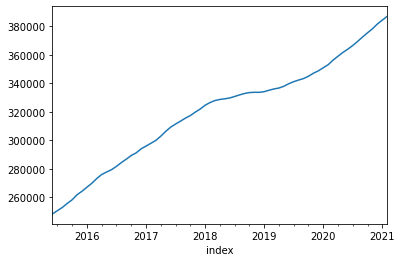

In [14]:
ts_df.avg_home_value.plot();

Appears to be trend without seasonality

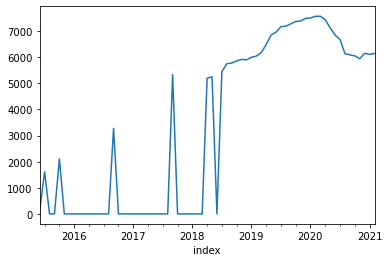

In [15]:
ts_df.inventory.plot();

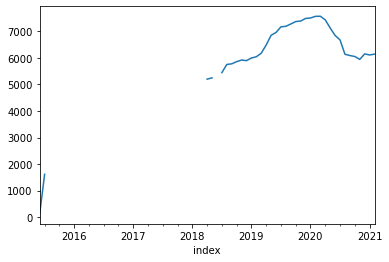

In [16]:
ts_df['inventory'] = ts_df['inventory'].replace(0,np.nan)
ts_df.inventory.plot();

Data appears to be missing throughout 2016 and 2017. Let's see what looking at just 2018 onward looks like.

## Focus on Dates after 2018

In [20]:
post_18_ts_df = ts_df['2018':]

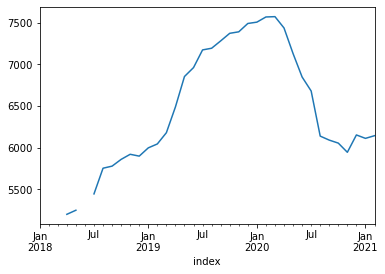

In [21]:
post_18_ts_df.inventory.plot();

There are still a handful of missing values. Let's use linear interpolation to fill in these values.

In [33]:
post_18_ts_df = post_18_ts_df.interpolate()

In [36]:
post_18_ts_df.dropna(inplace=True)

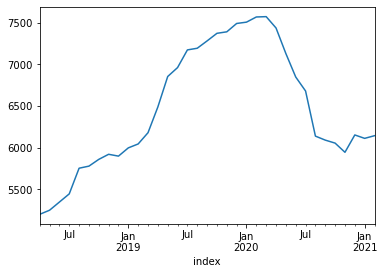

In [37]:
post_18_ts_df.inventory.plot();

## Interpolate Full Dataset

In [29]:
ts_df.interpolate(inplace=True)

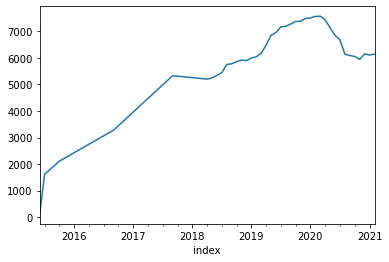

In [30]:
ts_df.inventory.plot();

We wil try modeling with both versions of the dataset.

# Decompose Time Series

In [102]:
result = seasonal_decompose(ts_df['avg_home_value'], model='add')

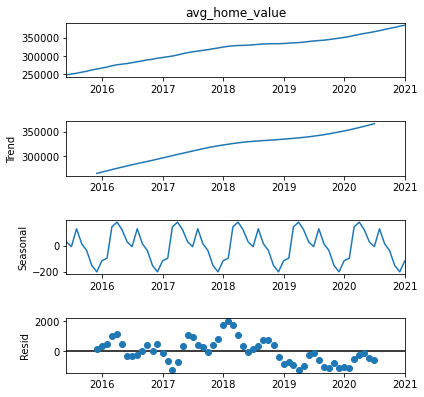

In [103]:
fig = result.plot()
fig.set_figheight(6)

# SARIMA Time Series Model

In [105]:
home_values = ts_df['avg_home_value']
home_values

index
2015-06-01    248302.80
2015-07-01    250573.92
2015-08-01    252813.76
2015-09-01    255660.52
2015-10-01    258221.84
                ...    
2020-09-01    372574.40
2020-10-01    375489.12
2020-11-01    378282.36
2020-12-01    381649.48
2021-01-01    384369.80
Name: avg_home_value, Length: 68, dtype: float64

## Parameter Selection for the SARIMA Model

In [114]:
# set seasonal s equal to 12
s=12
# allow p, d and q to take any value from 0 to 2
p = d = q = range(0,2)

# generate all combinations of p,d and q
pdq = list(itertools.product(p, d, q))

# generate all combinations including seasonal combinations
pdqs = [(x[0], x[1], x[2], s) for x in pdq]

In [117]:
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [119]:
# run grid with parameters above and select best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(home_values,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 1891.5809515479973
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 851116.8141147579
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 1267.8986831839766
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 986.2393796637208
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 1186.9989356681967
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1147.8243464815728
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 949.3077594301134
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 928.4010931358175
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 1818.8821459909045
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = 885978.0836485189
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 1261.3535569172625
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 1475.176911571501
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 1530.3626403905791
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = 1477.9009427208393
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 981.1951029979521
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 932.7272611403486
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 1205.60

In [120]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           651.192
Name: 54, dtype: object

In [122]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMA Model

In [123]:
SARIMA_MODEL = SARIMAX(home_values,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [124]:
output = SARIMA_MODEL.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   68
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -322.596
Date:                            Sun, 28 Mar 2021   AIC                            651.192
Time:                                    15:51:34   BIC                            656.405
Sample:                                06-01-2015   HQIC                           653.103
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9414      0.055     17.254      0.000       0.834       1.048
ar.S.L12      -0.6123      0.110     -5.573      0.000      -0.828      -0.397
sigma2      2.748e+05   6.01e+04      4.573      0.000    1.57e+05    3.93e+05
===================================================================================
Ljung-Box (Q):                       54.10   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.07   Prob(JB):                         0.83
Heteroskedasticity (H):               1.97   Skew:                             0.23
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Run Model Diagnostics

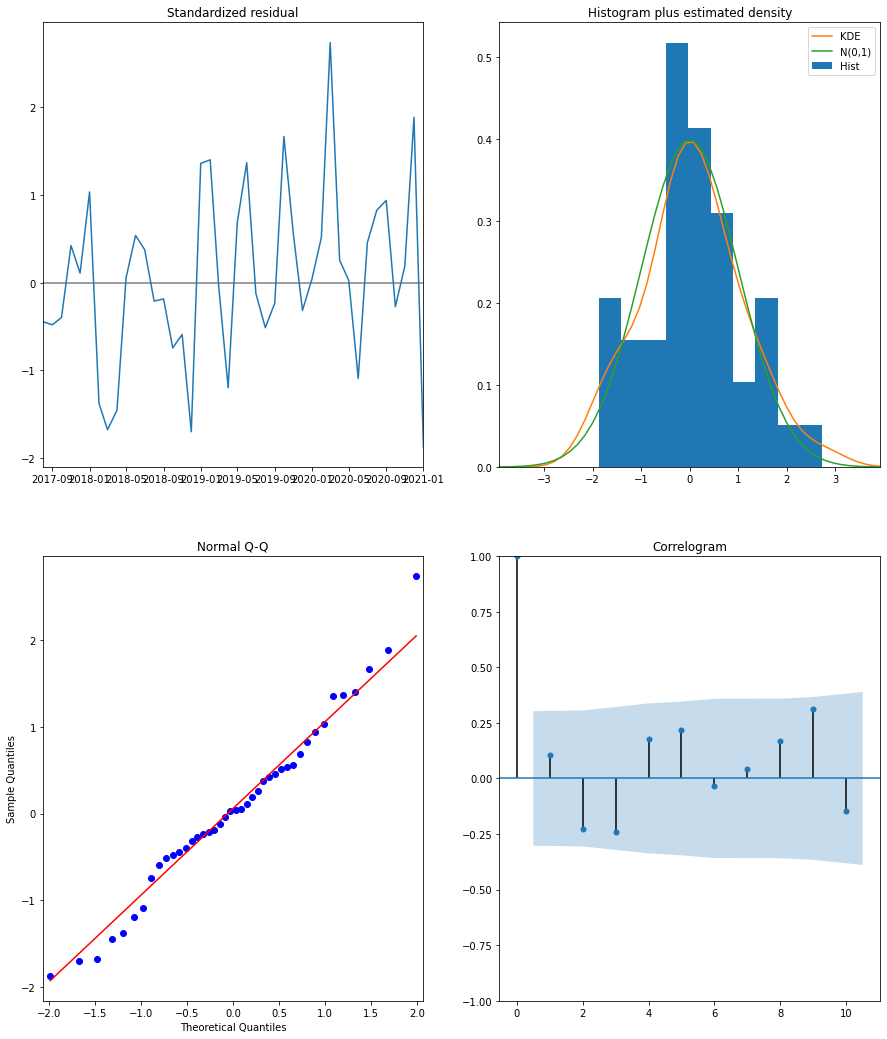

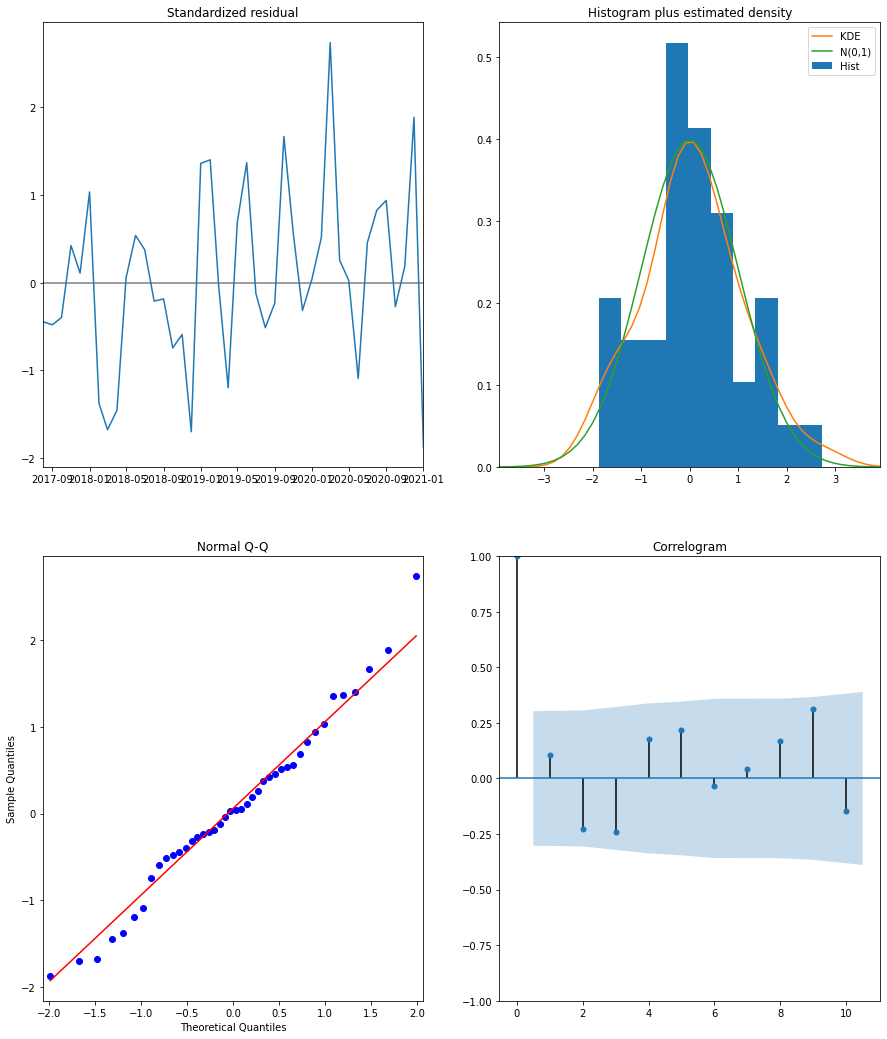

In [125]:
output.plot_diagnostics(figsize=(15,18))

It appears the residuals are normally distributed based on the KDE plot and the qq-plot, although there could be some violations at either tail.
The residuals appear to have white noise and not showing signs of seasonality. The residuals are also not highly correlated with themselves based on the autocorrelation plot.

## One-Step Ahead Forecasting

In [126]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_conf = pred.conf_int()

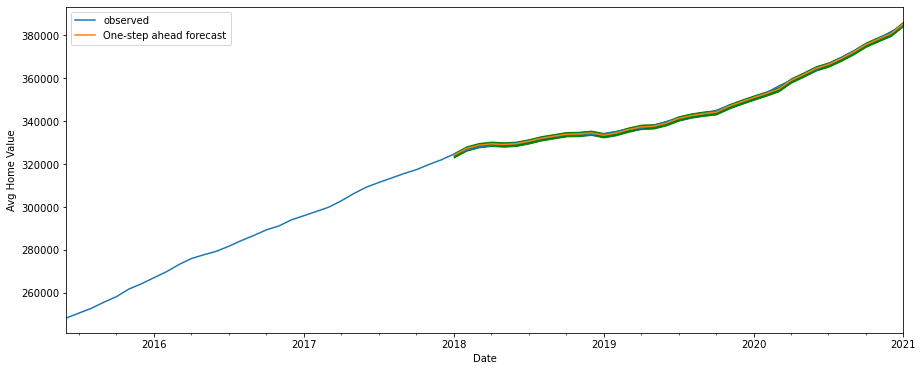

In [129]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [140]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

553.3314203454793


## Dynamic Forecast

In [141]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

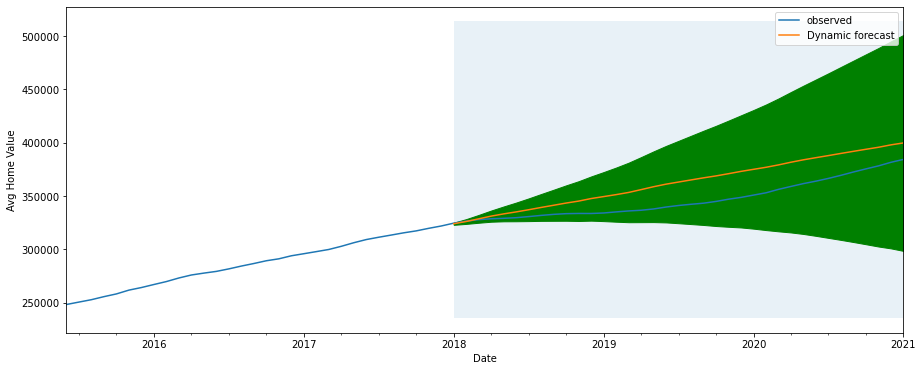

In [146]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g')

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [147]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

17720.371064235027


Much higher RMSE using a dynamic model.

## Predicting Future Values

In [151]:
prediction = output.get_forecast(steps=60)
pred_conf = prediction.conf_int()

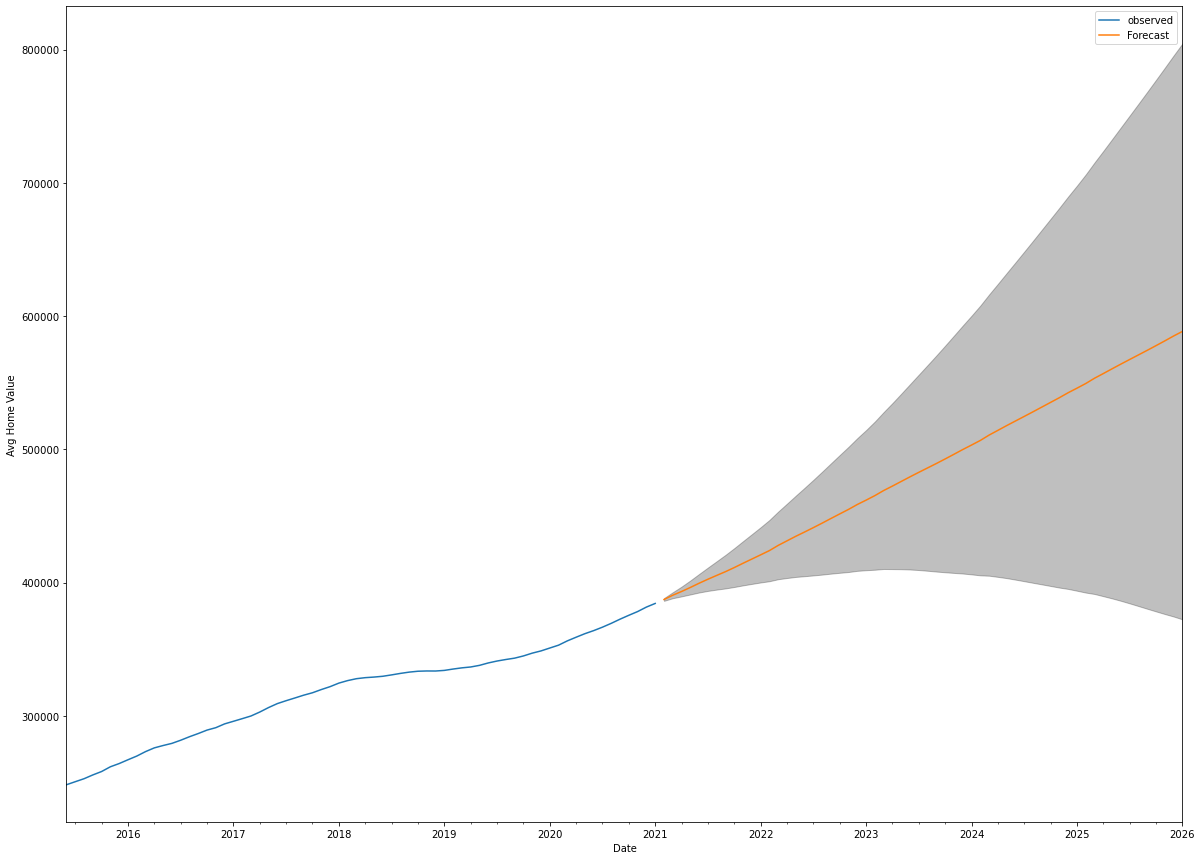

In [152]:
ax = home_values.plot(label='observed', figsize=(20,15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

# SARIMAX Time Series Model

## Parameter Selection for SARIMAX Model

# Create Target Variable

Our target will be the next month's average home value.

In [45]:
ts_df['actual_value'] = ts_df['avg_home_value'].shift(-1)
ts_df

,host_id,host_is_superhost,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,...,neighborhood_Midtown,neighborhood_North_Nashville,neighborhood_Parkwood,neighborhood_South_Nashville,neighborhood_Southeast_Nashville,neighborhood_West_Nashville,neighborhood_Whites_Creek,inventory,avg_home_value,actual_value
index,,,,,,,,,,,,,,,,,,,,,
2015-06-01,1.847859e+07,0.190083,2.355372,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,...,0.082645,0.049587,0.008264,0.123967,0.033058,0.066116,0.024793,121.0,248302.80,250573.92
2015-07-01,1.588542e+07,0.176471,10.465015,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,...,0.106502,0.030341,0.003715,0.128793,0.039009,0.072446,0.005573,1615.0,250573.92,252813.76
2015-08-01,1.678303e+07,0.186209,10.924070,37201.941558,36.157003,-86.767340,4.670198,1.509843,2.341373,201.740874,...,0.108284,0.032233,0.004057,0.126936,0.039118,0.071994,0.007349,1780.0,252813.76,255660.52
2015-09-01,1.768065e+07,0.195948,11.383125,37201.680021,36.156783,-86.767365,4.732967,1.519377,2.373767,201.132522,...,0.110066,0.034126,0.004398,0.125079,0.039227,0.071542,0.009125,1945.0,255660.52,258221.84
2015-10-01,1.857827e+07,0.205687,11.842180,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,...,0.111848,0.036019,0.004739,0.123223,0.039336,0.071090,0.010900,2110.0,258221.84,261785.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,1.089430e+08,0.583485,44.070025,37202.054170,36.161081,-86.769555,6.279273,1.912799,3.715442,212.609249,...,0.059785,0.111148,0.006276,0.156400,0.026259,0.053509,0.008092,6055.0,375489.12,378282.36
2020-11-01,1.117253e+08,0.576787,44.364508,37202.339950,36.160847,-86.770116,6.231287,1.907149,3.692683,211.482086,...,0.058537,0.115896,0.005551,0.156770,0.026913,0.054500,0.008242,5945.0,378282.36,381649.48
2020-12-01,1.180080e+08,0.568016,45.724200,37202.158459,36.160308,-86.769276,6.198440,1.906143,3.645701,212.335529,...,0.057045,0.110515,0.007151,0.154721,0.030879,0.054282,0.007639,6153.0,381649.48,384369.80


In [46]:
ts_df.dropna(inplace=True)

# Scaling Variables

## Scaling input features

In [47]:
ts_df.head()

,host_id,host_is_superhost,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,...,neighborhood_Midtown,neighborhood_North_Nashville,neighborhood_Parkwood,neighborhood_South_Nashville,neighborhood_Southeast_Nashville,neighborhood_West_Nashville,neighborhood_Whites_Creek,inventory,avg_home_value,actual_value
index,,,,,,,,,,,,,,,,,,,,,
2015-06-01,1.847859e+07,0.190083,2.355372,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,...,0.082645,0.049587,0.008264,0.123967,0.033058,0.066116,0.024793,121.0,248302.80,250573.92
2015-07-01,1.588542e+07,0.176471,10.465015,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,...,0.106502,0.030341,0.003715,0.128793,0.039009,0.072446,0.005573,1615.0,250573.92,252813.76
2015-08-01,1.678303e+07,0.186209,10.924070,37201.941558,36.157003,-86.767340,4.670198,1.509843,2.341373,201.740874,...,0.108284,0.032233,0.004057,0.126936,0.039118,0.071994,0.007349,1780.0,252813.76,255660.52
2015-09-01,1.768065e+07,0.195948,11.383125,37201.680021,36.156783,-86.767365,4.732967,1.519377,2.373767,201.132522,...,0.110066,0.034126,0.004398,0.125079,0.039227,0.071542,0.009125,1945.0,255660.52,258221.84
2015-10-01,1.857827e+07,0.205687,11.842180,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,...,0.111848,0.036019,0.004739,0.123223,0.039336,0.071090,0.010900,2110.0,258221.84,261785.56


In [48]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2015-06-01 to 2021-01-01
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_id                           68 non-null     float64
 1   host_is_superhost                 68 non-null     float64
 2   host_listings_count               68 non-null     float64
 3   zipcode                           68 non-null     float64
 4   latitude                          68 non-null     float64
 5   longitude                         68 non-null     float64
 6   accommodates                      68 non-null     float64
 7   bathrooms                         68 non-null     float64
 8   beds                              68 non-null     float64
 9   price                             68 non-null     float64
 10  guests_included                   68 non-null     float64
 11  minimum_nights                    68 non-null     flo

In [61]:
from sklearn.preprocessing import MinMaxScaler
features = ts_df.drop(columns=['host_id','actual_value'])
scale_input = MinMaxScaler(feature_range=(0,1))
scaled_features = scale_input.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)
X = scaled_features
X.index = ts_df.index

In [62]:
X

,host_is_superhost,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,guests_included,...,neighborhood_Madison,neighborhood_Midtown,neighborhood_North_Nashville,neighborhood_Parkwood,neighborhood_South_Nashville,neighborhood_Southeast_Nashville,neighborhood_West_Nashville,neighborhood_Whites_Creek,inventory,avg_home_value
index,,,,,,,,,,,,,,,,,,,,,
2015-06-01,0.030982,0.000000,0.691281,1.000000,0.273125,0.000000,0.000000,0.019149,0.061311,0.000000,...,0.218215,0.465549,0.224957,1.000000,0.155478,0.334178,0.409017,1.000000,0.000000,0.000000
2015-07-01,0.000000,0.058404,0.725684,0.259744,0.453796,0.184266,0.106881,0.178981,0.244713,0.257389,...,0.000000,0.886860,0.000000,0.052939,0.273169,0.555510,0.587960,0.000000,0.200510,0.016691
2015-08-01,0.022166,0.061710,0.639104,0.225120,0.449811,0.214364,0.127302,0.197746,0.241869,0.268292,...,0.219951,0.918335,0.022124,0.124009,0.227889,0.559566,0.575185,0.092396,0.222655,0.033152
2015-09-01,0.044332,0.065016,0.552523,0.190497,0.445826,0.244461,0.147723,0.216511,0.239026,0.279194,...,0.439901,0.949809,0.044247,0.195078,0.182609,0.563623,0.562410,0.184792,0.244799,0.054074
2015-10-01,0.066499,0.068322,0.465943,0.155873,0.441841,0.274558,0.168144,0.235276,0.236182,0.290097,...,0.659852,0.981284,0.066371,0.266148,0.137329,0.567679,0.549634,0.277187,0.266944,0.072898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,1.000000,0.298463,0.682418,0.906763,0.121643,1.000000,1.000000,1.000000,0.314150,0.119700,...,0.375463,0.070112,0.942583,0.578284,1.000000,0.063358,0.076205,0.111523,0.801235,0.913312
2020-10-01,0.926388,0.300419,0.676383,0.868702,0.090821,0.985913,0.990456,0.993700,0.292675,0.119700,...,0.259636,0.061855,0.944505,0.586006,0.946468,0.081342,0.052658,0.131095,0.796403,0.934733
2020-11-01,0.911144,0.302540,0.770988,0.831775,0.000000,0.962903,0.978352,0.980517,0.287406,0.119700,...,0.124386,0.039803,1.000000,0.435093,0.955509,0.105667,0.080646,0.138885,0.781640,0.955261


## Scaling Target Variable

In [59]:
scale_output = MinMaxScaler(feature_range=(0,1))
scaled_target = scale_output.fit_transform(ts_df[['actual_value']])
scaled_target = pd.DataFrame(scaled_target, columns=['actual_value'])
y = scaled_target
y.index = ts_df.index

In [60]:
y

,actual_value
index,
2015-06-01,0.000000
2015-07-01,0.016409
2015-08-01,0.037264
2015-09-01,0.056028
2015-10-01,0.082135
...,...
2020-09-01,0.915112
2020-10-01,0.935575
2020-11-01,0.960242


# Decompose Time Series

In [71]:
result = seasonal_decompose(y['actual_value'], model='add')

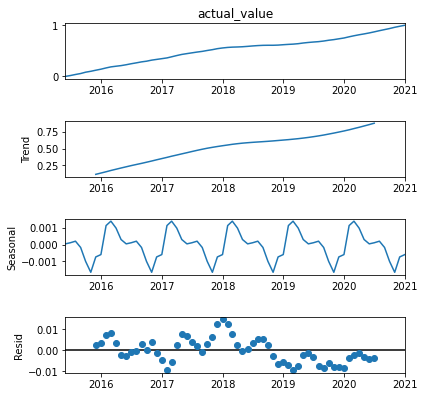

In [73]:
fig = result.plot()
fig.set_figheight(6)

# Check and Handle Data Stationarity

## Write function to check stationarity

In [77]:
def stationarity_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(8,5))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput

## Check Original Time Series stationarity

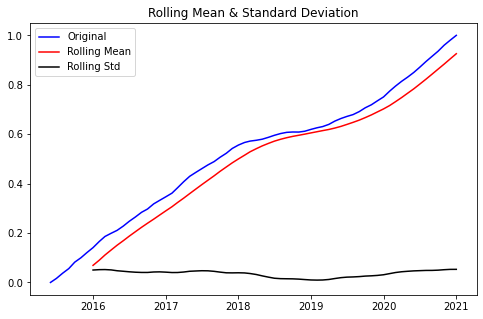

Test Statistic                 -0.894855
p-value                         0.789662
#Lags Used                     10.000000
Number of Observations Used    57.000000
dtype: float64

In [78]:
ts = y['actual_value']
stationarity_check(ts)

Because the p-value is much greater than 0.05, we cannot reject the null hypothesis that the data is not stationary.

## Differencing

In [88]:
ts_diff = ts.diff(periods=1)
ts_diff.dropna(inplace=True)

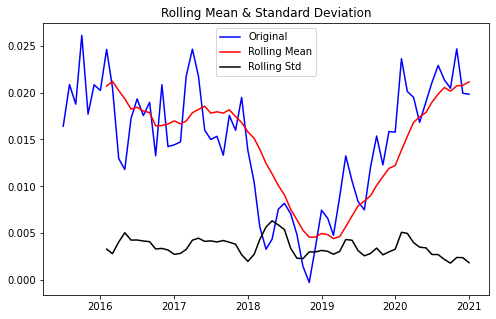

Test Statistic                 -2.959800
p-value                         0.038823
#Lags Used                     11.000000
Number of Observations Used    55.000000
dtype: float64

In [89]:
stationarity_check(ts_diff)

We can now reject the null hypothesis and confirm the data is stationary.

# Build Time Series Model

## Look at ACF and PACF plots

C:\Users\saman\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


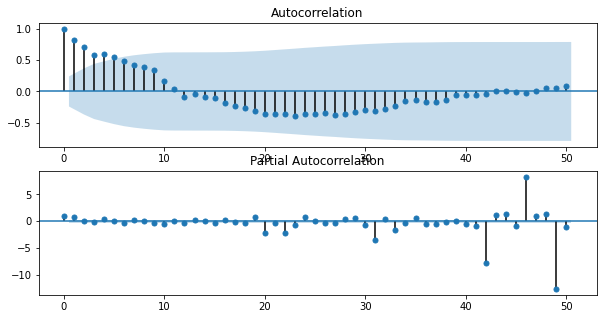

In [90]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(ts_diff, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(ts_diff, lags=50, ax=ax[1])
plt.show()

## Use Auto Arima

In [93]:
!pip install pmdarima

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [94]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(y, 
 exogenous= X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-513.328, Time=0.80 sec


C:\Users\saman\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\saman\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-519.330, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-516.776, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-458.747, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-305.706, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.076 seconds


In [95]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 307.665
Date:                Sun, 28 Mar 2021   AIC                           -519.330
Time:                        14:41:57   BIC                           -413.505
Sample:                    06-01-2015   HQIC                          -477.455
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                         1.133e-06      0.101   1.12e-05      1.000      -0.198       0.198
host_is_superhost                -1.264e+10      4.526  -2.79e+09      0.000   -1.26e+10   -1.26e+10
host_listings_count              -2.128e+09      1.487  -1.43e+09      0.000   -2.13e+09   -2.13e+09
zipcode                          -1.437e+08      1.543  -9.31e+07      0.000   -1.44e+08   -1.44e+08
latitude                          2.833e+08      6.988   4.05e+07      0.000    2.83e+08    2.83e+08
longitude                         9.257e+08      1.598   5.79e+08      0.000    9.26e+08    9.26e+08
accommodates                     -1.591e+11      3.295  -4.83e+10      0.000   -1.59e+11   -1.59e+11
bathrooms                         5.561e+10      2.386   2.33e+10      0.000    5.56e+10    5.56e+10
beds                              7.472e+09      3.415   2.19e+09      0.000    7.47e+09    7.47e+09
price                             1.148e+10      3.184    3.6e+09      0.000    1.15e+10    1.15e+10
guests_included                   4.873e+10      1.687   2.89e+10      0.000    4.87e+10    4.87e+10
minimum_nights                   -2.136e+10      3.411  -6.26e+09      0.000   -2.14e+10   -2.14e+10
maximum_nights                     2.59e+09      0.954   2.72e+09      0.000    2.59e+09    2.59e+09
availability_30                  -2.288e+10      1.251  -1.83e+10      0.000   -2.29e+10   -2.29e+10
availability_60                   3.927e+10      2.466   1.59e+10      0.000    3.93e+10    3.93e+10
availability_90                  -1.193e+10      2.364  -5.05e+09      0.000   -1.19e+10   -1.19e+10
number_of_reviews                -2.421e+10      7.190  -3.37e+09      0.000   -2.42e+10   -2.42e+10
review_scores_rating              1.326e+09      4.862   2.73e+08      0.000    1.33e+09    1.33e+09
review_scores_accuracy           -4.091e+09      1.296  -3.16e+09      0.000   -4.09e+09   -4.09e+09
review_scores_cleanliness        -5.935e+10      2.812  -2.11e+10      0.000   -5.94e+10   -5.94e+10
review_scores_checkin            -2.126e+10      0.742  -2.87e+10      0.000   -2.13e+10   -2.13e+10
review_scores_communication       5.865e+09      1.946   3.01e+09      0.000    5.87e+09    5.87e+09
review_scores_location           -2.023e+10      4.755  -4.25e+09      0.000   -2.02e+10   -2.02e+10
review_scores_value               6.191e+10      2.788   2.22e+10      0.000    6.19e+10    6.19e+10
instant_bookable                 -1.757e+09      2.536  -6.93e+08      0.000   -1.76e+09   -1.76e+09
reviews_per_month                  1.62e+10      1.179   1.37e+10      0.000    1.62e+10    1.62e+10
property_type_Condominium        -2.683e+10      3.911  -6.86e+09      0.000   -2.68e+10   -2.68e+10
property_type_House              -2.863e+10      3.492   -8.2e+09      0.000   -2.86e+10   -2.86e+10
property_type_Other               7.055e+10      3.762   1.88e+10      0.000    7.05e+10    7.05e+10
property_

## Train the Model

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(y, 
               exog=X,
               order=(0,1,0),
               enforce_invertibility=False, enforce_stationarity=False)

C:\Users\saman\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\saman\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [98]:
results = model.fit()

C:\Users\saman\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [101]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           actual_value   No. Observations:                   68
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 227.208
Date:                Sun, 28 Mar 2021   AIC                           -360.417
Time:                        14:45:24   BIC                           -257.503
Sample:                    06-01-2015   HQIC                          -319.751
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
host_is_superhost                -1.264e+10      0.478  -2.65e+10      0.000   -1.26e+10   -1.26e+10
host_listings_count              -2.128e+09      0.142  -1.49e+10      0.000   -2.13e+09   -2.13e+09
zipcode                          -1.437e+08      0.180  -7.97e+08      0.000   -1.44e+08   -1.44e+08
latitude                          2.833e+08      0.481    5.9e+08      0.000    2.83e+08    2.83e+08
longitude                         9.257e+08      0.332   2.78e+09      0.000    9.26e+08    9.26e+08
accommodates                     -1.591e+11      0.490  -3.25e+11      0.000   -1.59e+11   -1.59e+11
bathrooms                         5.561e+10      0.339   1.64e+11      0.000    5.56e+10    5.56e+10
beds                              7.472e+09      0.670   1.12e+10      0.000    7.47e+09    7.47e+09
price                             1.148e+10      0.651   1.76e+10      0.000    1.15e+10    1.15e+10
guests_included                   4.873e+10      0.621   7.85e+10      0.000    4.87e+10    4.87e+10
minimum_nights                   -2.136e+10      0.289  -7.38e+10      0.000   -2.14e+10   -2.14e+10
maximum_nights                     2.59e+09      0.090   2.89e+10      0.000    2.59e+09    2.59e+09
availability_30                  -2.288e+10      0.255  -8.97e+10      0.000   -2.29e+10   -2.29e+10
availability_60                   3.927e+10      0.100   3.92e+11      0.000    3.93e+10    3.93e+10
availability_90                  -1.193e+10      0.137  -8.69e+10      0.000   -1.19e+10   -1.19e+10
number_of_reviews                -2.421e+10      0.618  -3.92e+10      0.000   -2.42e+10   -2.42e+10
review_scores_rating              1.326e+09      0.505   2.62e+09      0.000    1.33e+09    1.33e+09
review_scores_accuracy           -4.091e+09      0.601  -6.81e+09      0.000   -4.09e+09   -4.09e+09
review_scores_cleanliness        -5.935e+10      0.349   -1.7e+11      0.000   -5.94e+10   -5.94e+10
review_scores_checkin            -2.126e+10      0.197  -1.08e+11      0.000   -2.13e+10   -2.13e+10
review_scores_communication       5.865e+09      0.156   3.75e+10      0.000    5.87e+09    5.87e+09
review_scores_location           -2.023e+10      0.277   -7.3e+10      0.000   -2.02e+10   -2.02e+10
review_scores_value               6.191e+10      0.203   3.05e+11      0.000    6.19e+10    6.19e+10
instant_bookable                 -1.757e+09      0.328  -5.36e+09      0.000   -1.76e+09   -1.76e+09
reviews_per_month                  1.62e+10      0.208    7.8e+10      0.000    1.62e+10    1.62e+10
property_type_Condominium        -2.683e+10      0.671     -4e+10      0.000   -2.68e+10   -2.68e+10
property_type_House              -2.863e+10      1.057  -2.71e+10      0.000   -2.86e+10   -2.86e+10
property_type_Other               7.055e+10      1.300   5.43e+10      0.000    7.05e+10    7.05e+10
property_type_Townhouse           9.625e+10      0.309   3.11e+11      0.000    9.62e+10    9.62e+10
room_type

In [99]:
forecast_1= results.forecast(steps=10, exog=X)

ValueError: Provided exogenous values are not of the appropriate shape. Required (10, 46), got (68, 46).

In [20]:
ts_df = pd.read_csv("cleaned_data/ts_data_clean.csv")
ts_df.head()

,Unnamed: 0,host_id,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,inventory,total_average
0,2015-06-01,1.847859e+07,37202.099174,36.161913,-86.768430,4.223140,1.433884,1.619835,2.033058,163.115702,1.859504,1.545455,889.553719,17.206612,121.0,248302.80
1,2015-07-01,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.492879,1.758514,2.308978,202.349226,2.161610,1.698452,838.203715,16.536223,1615.0,250573.92
2,2015-08-01,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.492879,1.758514,2.308978,202.349226,2.161610,1.698452,838.203715,16.536223,1615.0,252813.76
3,2015-09-01,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.492879,1.758514,2.308978,202.349226,2.161610,1.698452,838.203715,16.536223,1615.0,255660.52
4,2015-10-01,1.857827e+07,37201.418483,36.156564,-86.767390,4.795735,1.522275,1.800000,2.406161,200.524171,2.200000,1.747867,836.094313,17.715640,2110.0,258221.84


In [21]:
ts_df['date'] = pd.to_datetime(ts_df['Unnamed: 0'])

In [23]:
ts_df = ts_df.set_index('date')

In [26]:
ts_df.drop('Unnamed: 0', inplace=True, axis=1)

In [27]:
ts_df.index 

DatetimeIndex(['2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
      

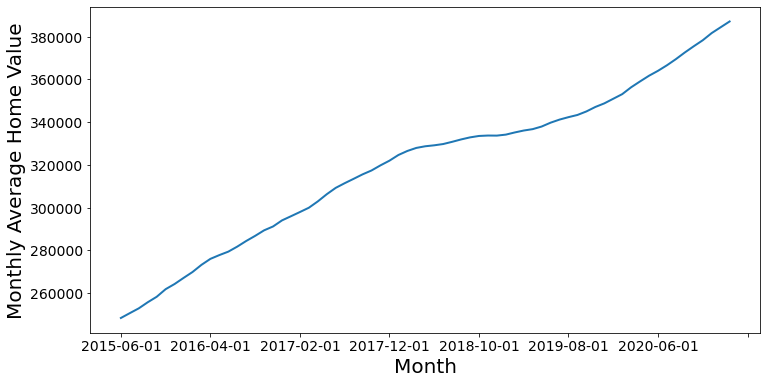

In [11]:
ts_df.total_average.plot(figsize=(12,6),linewidth=2, fontsize=14)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Monthly Average Home Value', fontsize=20);

In [12]:
roll_mean =ts_df.total_average.rolling(window=8, center=False).mean()

This appears to be an upward linear trend.

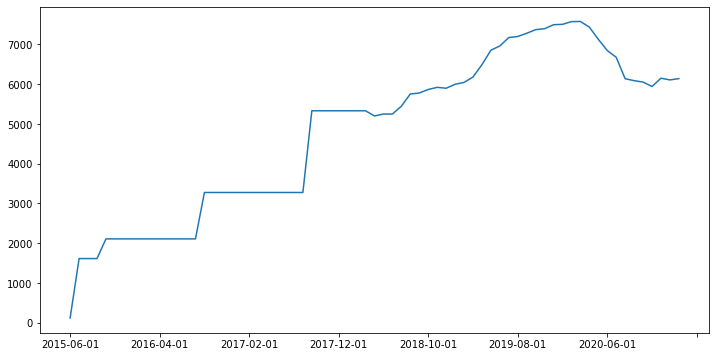

In [9]:
ts_df.inventory.plot(figsize=(12,6))

## Decomposing Home Value Series

In [28]:
series = ts_df.total_average

In [18]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   host_id            69 non-null     float64
 1   zipcode            69 non-null     float64
 2   latitude           69 non-null     float64
 3   longitude          69 non-null     float64
 4   accommodates       69 non-null     float64
 5   bathrooms          69 non-null     float64
 6   bedrooms           69 non-null     float64
 7   beds               69 non-null     float64
 8   price              69 non-null     float64
 9   guests_included    69 non-null     float64
 10  minimum_nights     69 non-null     float64
 11  maximum_nights     69 non-null     float64
 12  number_of_reviews  69 non-null     float64
 13  inventory          69 non-null     float64
 14  total_average      69 non-null     float64
dtypes: float64(15)
memory usage: 11.1+ KB


In [16]:
ts_df.total_average

2015-06-01    248302.80
2015-07-01    250573.92
2015-08-01    252813.76
2015-09-01    255660.52
2015-10-01    258221.84
                ...    
2020-10-01    375489.12
2020-11-01    378282.36
2020-12-01    381649.48
2021-01-01    384369.80
2021-02-01    387076.52
Name: total_average, Length: 69, dtype: float64

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
result = seasonal_decompose(series, model='additive')

In [30]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

date
2015-06-01   NaN
2015-07-01   NaN
2015-08-01   NaN
2015-09-01   NaN
2015-10-01   NaN
              ..
2020-10-01   NaN
2020-11-01   NaN
2020-12-01   NaN
2021-01-01   NaN
2021-02-01   NaN
Name: trend, Length: 69, dtype: float64
date
2015-06-01     37.855764
2015-07-01      2.265097
2015-08-01     11.361764
2015-09-01     24.166097
2015-10-01    -27.102236
                 ...    
2020-10-01    -27.102236
2020-11-01   -141.009736
2020-12-01   -188.825903
2021-01-01   -104.716903
2021-02-01    -85.290903
Name: seasonal, Length: 69, dtype: float64
date
2015-06-01   NaN
2015-07-01   NaN
2015-08-01   NaN
2015-09-01   NaN
2015-10-01   NaN
              ..
2020-10-01   NaN
2020-11-01   NaN
2020-12-01   NaN
2021-01-01   NaN
2021-02-01   NaN
Name: resid, Length: 69, dtype: float64
date
2015-06-01    248302.80
2015-07-01    250573.92
2015-08-01    252813.76
2015-09-01    255660.52
2015-10-01    258221.84
                ...    
2020-10-01    375489.12
2020-11-01    378282.36
2020-12-01    38

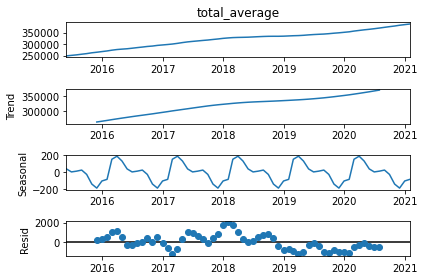

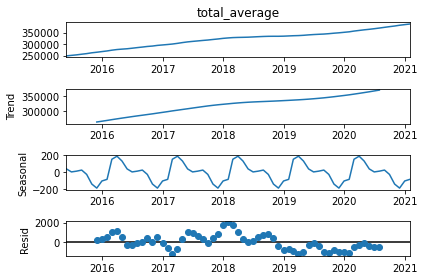

In [31]:
result.plot()

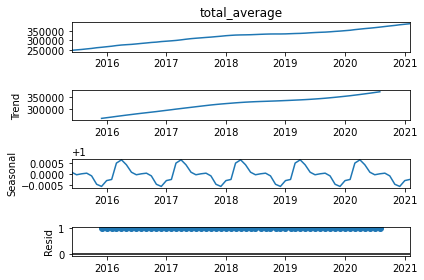

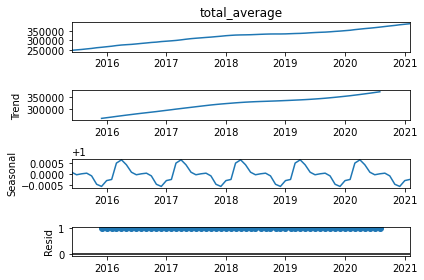

In [32]:
result_2 = seasonal_decompose(series, model='multiplicative')
result_2.plot()

In [34]:
series_diff = series.diff(periods=1)

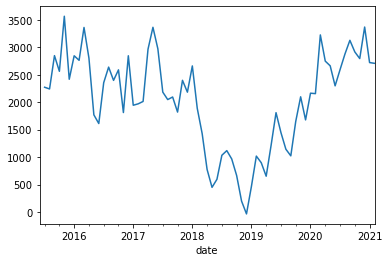

In [35]:
series_diff.plot()

In [36]:
ts_df.corr()

,host_id,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,inventory,total_average
host_id,1.000000,0.538785,0.863693,-0.692372,0.978074,-0.079532,0.600457,0.908921,0.606363,-0.048540,0.857698,-0.403114,0.981752,0.909419,0.960038
zipcode,0.538785,1.000000,0.651643,-0.633447,0.511544,0.261809,0.204277,0.463274,0.585483,0.241153,0.355687,-0.562263,0.572900,0.540272,0.398397
latitude,0.863693,0.651643,1.000000,-0.857774,0.801146,0.074601,0.426883,0.746285,0.597166,0.095911,0.637846,-0.607527,0.858906,0.801508,0.748804
longitude,-0.692372,-0.633447,-0.857774,1.000000,-0.639043,-0.081267,-0.305333,-0.595009,-0.471969,-0.140519,-0.495171,0.822394,-0.681018,-0.630287,-0.567925
accommodates,0.978074,0.511544,0.801146,-0.639043,1.000000,0.018878,0.603738,0.912790,0.620681,0.062360,0.787277,-0.314362,0.986825,0.949982,0.970906
bathrooms,-0.079532,0.261809,0.074601,-0.081267,0.018878,1.000000,-0.312461,-0.125096,0.421314,0.970158,-0.471035,0.048883,0.049412,0.265325,-0.083091
bedrooms,0.600457,0.204277,0.426883,-0.305333,0.603738,-0.312461,1.000000,0.861697,0.504491,-0.226320,0.722799,-0.118134,0.597109,0.553215,0.615909
beds,0.908921,0.463274,0.746285,-0.595009,0.912790,-0.125096,0.861697,1.000000,0.685012,-0.065872,0.844517,-0.322717,0.908780,0.855636,0.891305
price,0.606363,0.585483,0.597166,-0.471969,0.620681,0.421314,0.504491,0.685012,1.000000,0.351777,0.423484,-0.372361,0.639522,0.688971,0.522351
guests_included,-0.048540,0.241153,0.095911,-0.140519,0.062360,0.970158,-0.226320,-0.065872,0.351777,1.000000,-0.437936,0.060980,0.093645,0.314482,-0.031594


In [37]:
ts_df_diff = ts_df.diff(periods=1)

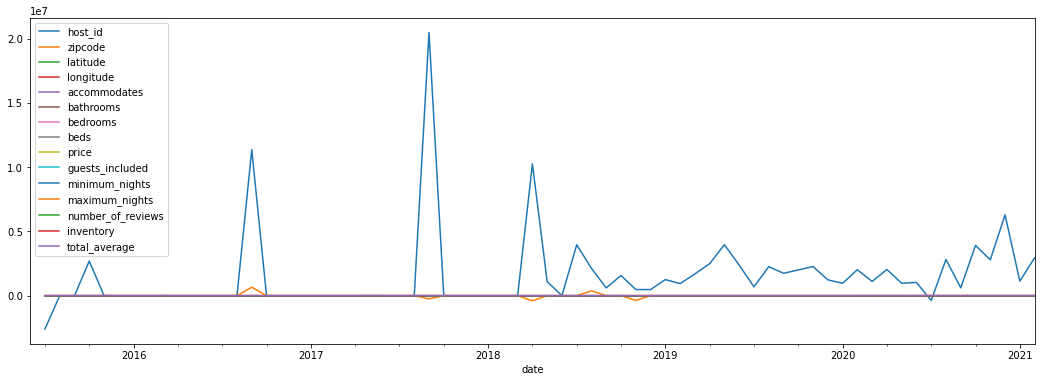

In [39]:
ts_df_diff.plot(figsize=(18,6));

In [40]:
ts_df_diff.corr()

,host_id,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,inventory,total_average
host_id,1.000000,0.041262,0.402369,-0.345044,0.529352,0.047891,0.121091,0.196341,0.095239,0.133144,0.217555,-0.049496,0.785076,0.603959,-0.073016
zipcode,0.041262,1.000000,0.019206,-0.206195,0.005736,0.067484,-0.053122,-0.062269,0.046434,0.023503,-0.055540,0.033437,0.030350,-0.006373,-0.047739
latitude,0.402369,0.019206,1.000000,-0.494768,-0.329520,-0.056311,-0.017663,-0.025787,-0.073661,-0.098225,-0.055281,-0.239121,0.204988,-0.081066,-0.134173
longitude,-0.345044,-0.206195,-0.494768,1.000000,-0.021290,-0.138268,0.135841,0.089410,0.063061,-0.188531,0.213280,0.689939,-0.142761,-0.094012,0.116577
accommodates,0.529352,0.005736,-0.329520,-0.021290,1.000000,0.060225,0.177682,0.269692,0.179593,0.182670,0.061664,0.059570,0.625420,0.732623,-0.085467
bathrooms,0.047891,0.067484,-0.056311,-0.138268,0.060225,1.000000,-0.720659,-0.665930,-0.252217,0.980343,-0.642546,-0.011492,-0.128890,0.323022,-0.123158
bedrooms,0.121091,-0.053122,-0.017663,0.135841,0.177682,-0.720659,1.000000,0.986735,0.824410,-0.678109,0.821780,0.023590,0.248396,-0.008756,0.036742
beds,0.196341,-0.062269,-0.025787,0.089410,0.269692,-0.665930,0.986735,1.000000,0.851407,-0.609938,0.800090,-0.019517,0.325669,0.051911,0.010663
price,0.095239,0.046434,-0.073661,0.063061,0.179593,-0.252217,0.824410,0.851407,1.000000,-0.227423,0.648626,-0.032581,0.124523,0.116901,-0.059075
guests_included,0.133144,0.023503,-0.098225,-0.188531,0.182670,0.980343,-0.678109,-0.609938,-0.227423,1.000000,-0.609689,-0.049952,-0.028705,0.416178,-0.119217


In [41]:
home_values = ts_df[['total_average']]

In [42]:
home_values_shift_1 = home_values.shift(periods=1)
home_values_shift_1

,total_average
date,
2015-06-01,NaN
2015-07-01,248302.80
2015-08-01,250573.92
2015-09-01,252813.76
2015-10-01,255660.52
...,...
2020-10-01,372574.40
2020-11-01,375489.12
2020-12-01,378282.36


In [43]:
lag_1 = pd.concat([home_values_shift_1, home_values], axis=1)

lag_1.corr()

,total_average,total_average
total_average,1.000000,0.999716
total_average,0.999716,1.000000


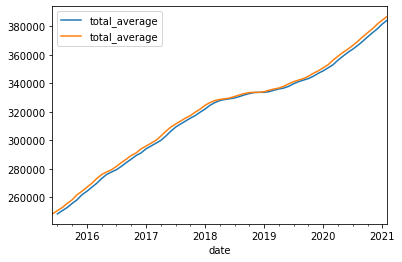

In [45]:
lag_1.plot();

In [46]:
home_values_shift_12 = home_values.shift(periods=12)
home_values_shift_12

,total_average
date,
2015-06-01,NaN
2015-07-01,NaN
2015-08-01,NaN
2015-09-01,NaN
2015-10-01,NaN
...,...
2020-10-01,344962.96
2020-11-01,347060.04
2020-12-01,348736.72


In [47]:
lag_12 = pd.concat([home_values_shift_12, home_values], axis=1)

lag_12.corr()

,total_average,total_average
total_average,1.000000,0.965114
total_average,0.965114,1.000000


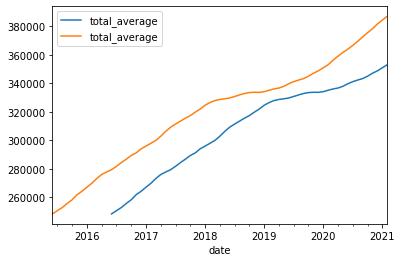

In [48]:
lag_12.plot();

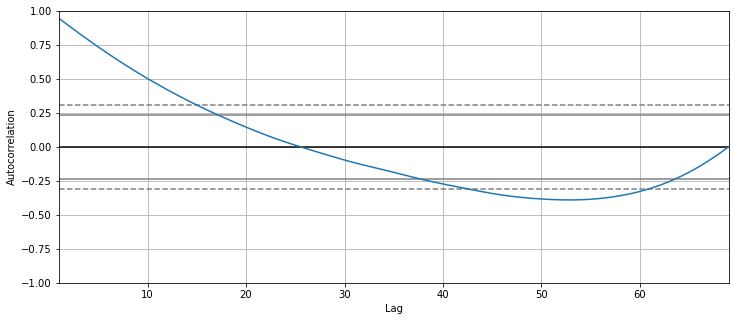

In [49]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(home_values);

C:\Users\saman\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


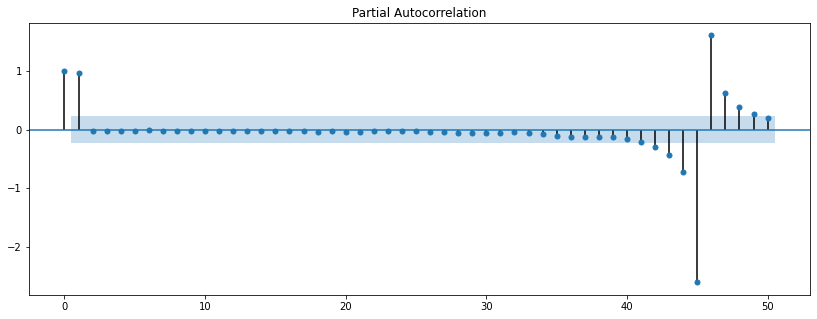

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(home_values, lags=50);

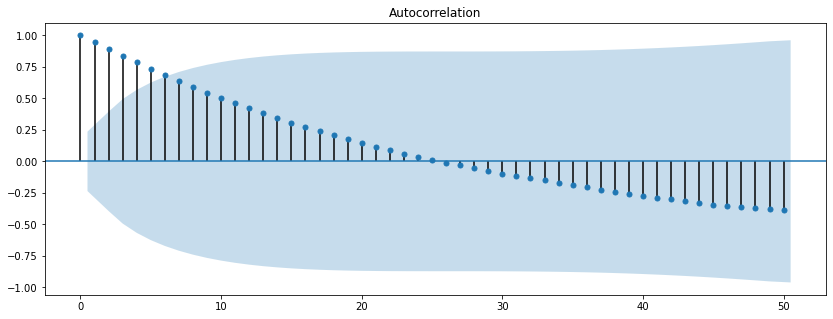

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(home_values, lags=50);

## ARMA Model

In [58]:
home_values_diff = home_values.diff(periods=1)

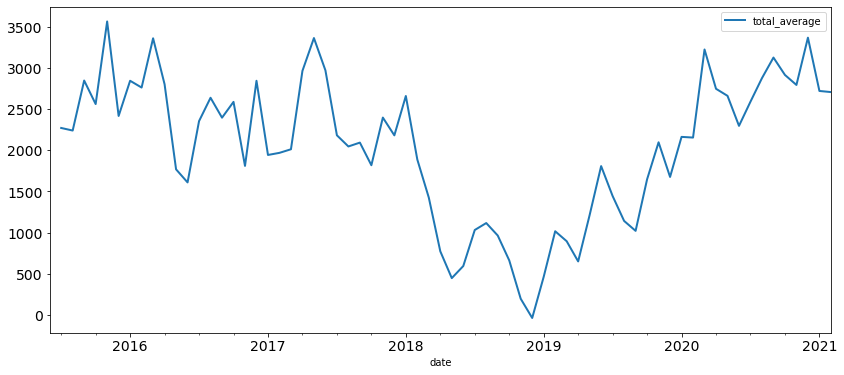

In [59]:
home_values_diff.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [60]:
home_values_log =np.log(home_values)

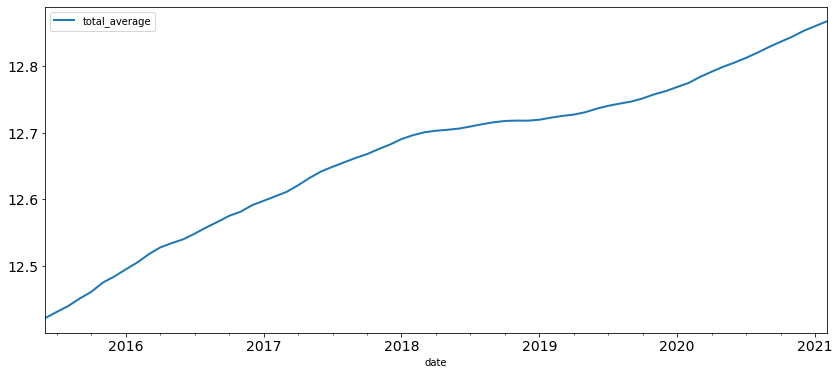

In [61]:
home_values_log.plot(figsize=(14,6), linewidth=2, fontsize=14);

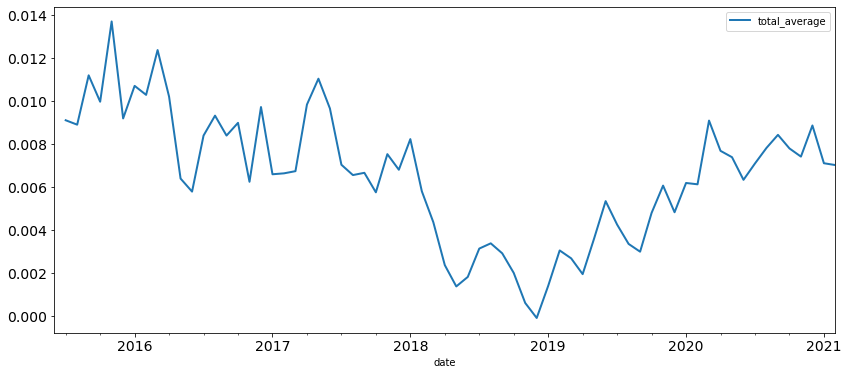

In [62]:
home_values_log_diff = home_values_log.diff(periods=1)
home_values_log_diff.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [70]:
home_values_log_diff.dropna(inplace=True)

In [71]:
home_values_diff.dropna(inplace=True)

In [65]:
from statsmodels.tsa.stattools import adfuller

In [66]:
def stationarity_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(12,7))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput

In [73]:
adfuller(home_values)

(-0.057461158621744036,
 0.9535141627984719,
 10,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 846.0936277735087)

In [72]:
adfuller(home_values_diff)

(-3.0091693994208466,
 0.03404692150853294,
 11,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 828.1739738839484)

In [74]:
adfuller(home_values_log_diff)

(-2.340649836438658,
 0.15919244155804468,
 11,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 -591.0742711171613)

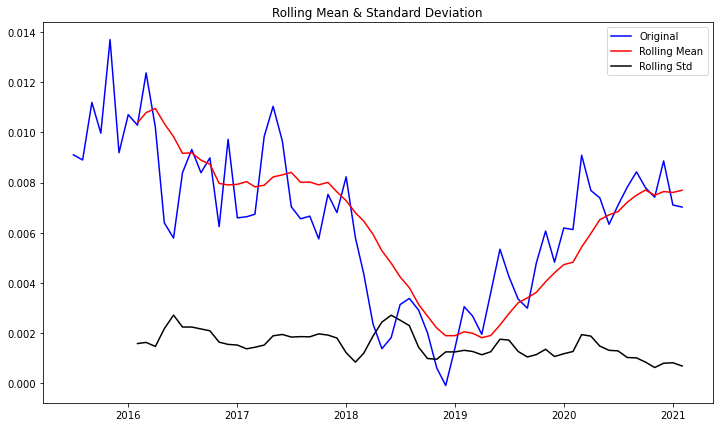

Test Statistic                 -2.340650
p-value                         0.159192
#Lags Used                     11.000000
Number of Observations Used    56.000000
dtype: float64

In [75]:
stationarity_check(home_values_log_diff)

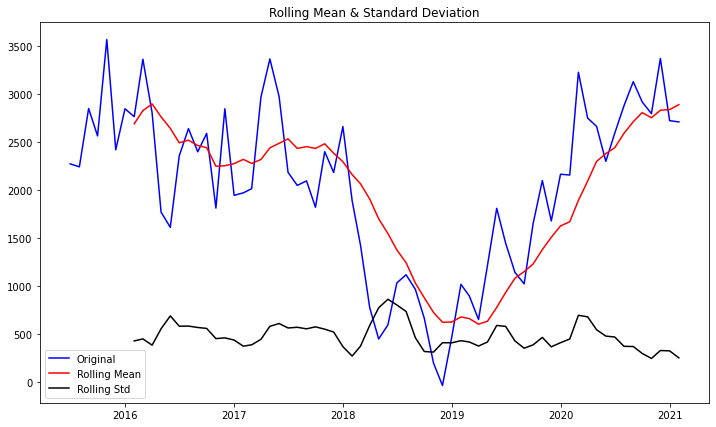

Test Statistic                 -3.009169
p-value                         0.034047
#Lags Used                     11.000000
Number of Observations Used    56.000000
dtype: float64

In [76]:
stationarity_check(home_values_diff)

In [77]:
decomposition = seasonal_decompose(home_values_diff)

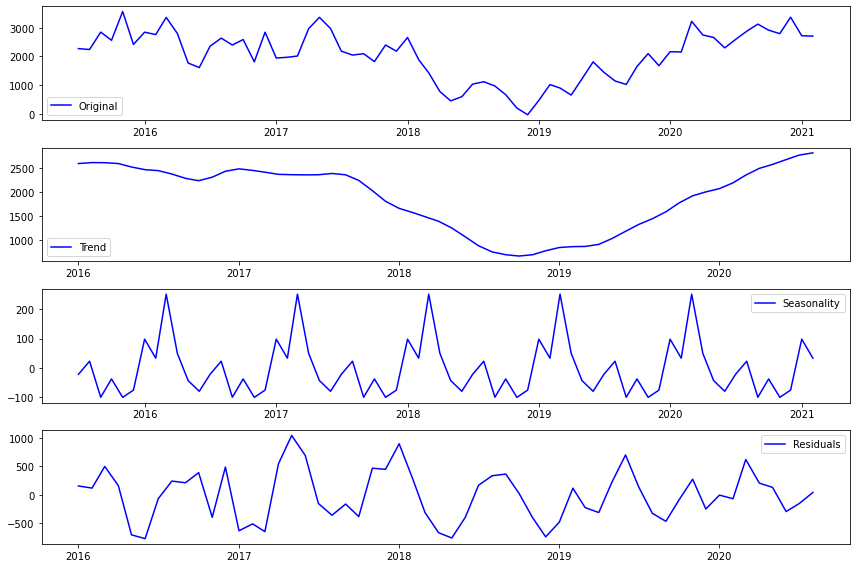

In [79]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(home_values_diff, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

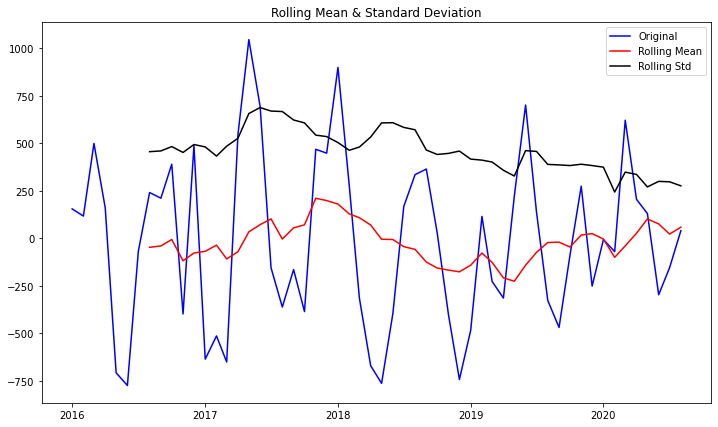

Test Statistic                 -1.889160
p-value                         0.337178
#Lags Used                      7.000000
Number of Observations Used    48.000000
dtype: float64

In [80]:
home_values_diff_decompose = residual
home_values_diff_decompose.dropna(inplace=True)
stationarity_check(home_values_diff_decompose)

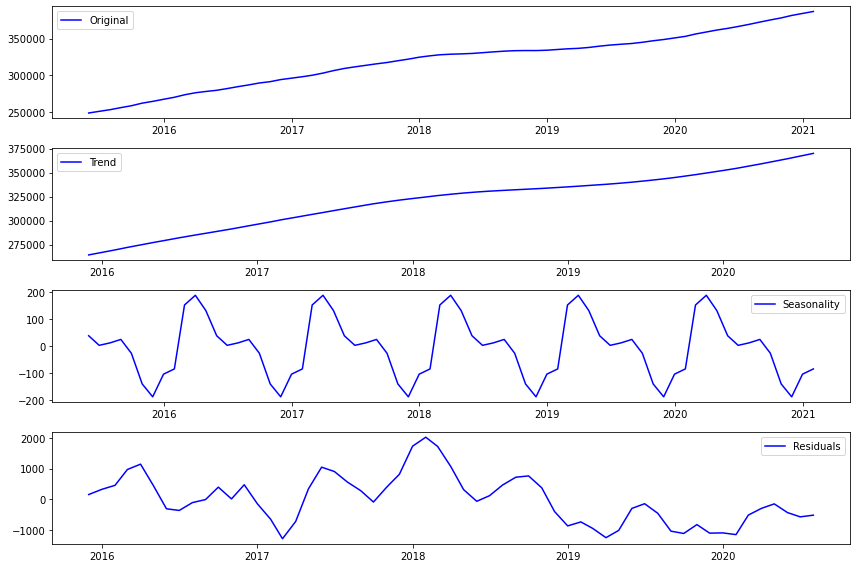

In [81]:
decomposition = seasonal_decompose(home_values)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(home_values, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

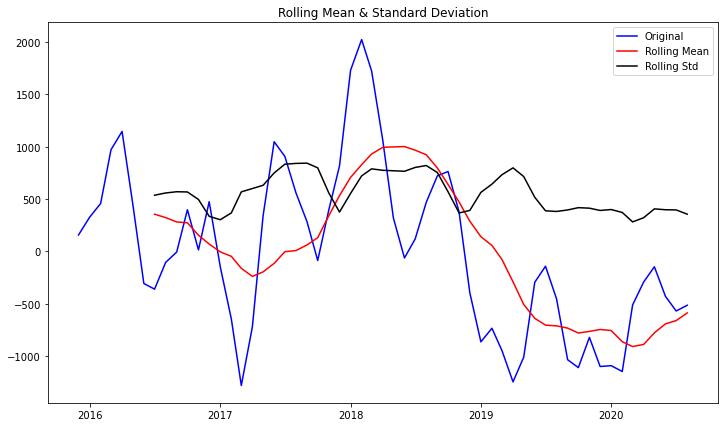

Test Statistic                 -2.419213
p-value                         0.136387
#Lags Used                      9.000000
Number of Observations Used    47.000000
dtype: float64

In [82]:
home_values_decompose = residual
home_values_decompose.dropna(inplace=True)
stationarity_check(home_values_decompose)